In [1]:
from torch import nn
from torch.optim import Adam
import torch
from math import ceil

class CNN(nn.Module):
    def __init__(self, num_actions, input_shape=(96, 96, 3), lr = 1e-5, softmax = True):
        super(CNN, self).__init__()

        self.input_channels = input_shape[-1]
        self.input_size = input_shape[:-1]
        self.num_actions = num_actions
        
        kernel_size = 5
        conv_layers = [
            nn.Conv2d(self.input_channels, 16, bias = False, kernel_size = kernel_size, stride=2, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=1, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=2, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=1, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=2, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=1, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=2, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size = kernel_size, bias = False, stride=1, padding = kernel_size//2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm2d(16)]
        
        mlp_layers = [
            nn.Flatten(),
            nn.Linear(16 * ceil(self.input_size[0] / 2**4) * ceil(self.input_size[1] / 2**4), 16),
            nn.LeakyReLU(0.01),
            nn.Linear(16, num_actions)
        ]

        self.softmax = softmax
        if self.softmax:
            mlp_layers.append(nn.Softmax(dim = -1))
        self.q1 = nn.Sequential(*conv_layers)
        self.q2 = nn.Sequential(*mlp_layers)

        self.optim = Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2).float()
        x = self.q1(x)
        return self.q2(x)

In [2]:
from torchsummary import summary
model = CNN(3)
print(model)
summary(model, (96, 96, 3), device="cpu")

CNN(
  (q1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (13): LeakyReLU(ne

In [3]:
from copy import deepcopy
import numpy as np
import time

def train_qlearn_cuda(model, env, num_episodes=1000, gamma=0.9, epsilon_decay=0.9):
    import torch
    import torch.nn as nn

    device = "cuda"

    # Create target model (on GPU)
    target_model = deepcopy(model)
    target_model.load_state_dict(model.state_dict())
    target_model.to(device)
    model.to(device)

    # Create CPU model for env interaction
    cpu_model = deepcopy(model)
    cpu_model.load_state_dict(model.state_dict())
    cpu_model.to("cpu")

    current_index = 0
    buffer_size = 4096
    state_shape = env.observation_space.shape

    # Keep replay buffer on GPU
    states_buffer = torch.zeros((buffer_size, *state_shape), dtype=torch.float32, device=device)
    actions_buffer = torch.zeros((buffer_size,), dtype=torch.int64, device=device)
    rewards_buffer = torch.zeros((buffer_size,), dtype=torch.float32, device=device)
    dones_buffer = torch.zeros((buffer_size,), dtype=torch.bool, device=device)
    rewards_history = []

    epsilon = 1
    try:
        for e in range(num_episodes):
            state, *_ = env.reset()
            state = torch.from_numpy(np.array(state)).float()  # keep on CPU for env
            done = False

            total_reward = 0

            elapsed_time = 0
            total_action_time = 0 
            total_step_time = 0
            total_sample_time = 0
            total_q_time = 0
            total_train_time = 0

            while not done:
                start_time = time.perf_counter()
                # Choose action
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        states_tensor = state.unsqueeze(0)  # still on CPU
                        q_values = cpu_model(states_tensor)
                        action = torch.argmax(q_values, dim=1).item()

                action_time = time.perf_counter() 
                total_action_time += action_time - start_time

                # Take action
                next_state, reward, terminal, truncated, _ = env.step(action)
                next_state = torch.from_numpy(np.array(next_state)).float()  # keep on CPU
                done = terminal or truncated
                total_reward += reward

                # Store transition in memory (move to GPU)
                index = current_index % buffer_size
                states_buffer[index] = state.to(device)
                actions_buffer[index] = torch.tensor(action, dtype=torch.int64, device=device)
                rewards_buffer[index] = torch.tensor(reward, dtype=torch.float32, device=device)
                dones_buffer[index] = torch.tensor(done, dtype=torch.bool, device=device)
                current_index += 1

                step_time = time.perf_counter()
                total_step_time += step_time - action_time

                # Update state
                state = next_state

            # Append total reward to history
            rewards_history.append(total_reward)

            # Train the model
            if current_index > 1000:
                batch_size = 128
                for i in range(4 * current_index//batch_size):
                    step_time = time.perf_counter()
                    idx = np.random.choice(min(current_index, buffer_size) - 1, batch_size, replace=False)

                    # All buffers are already on GPU
                    states_tensor = states_buffer[idx]
                    actions_tensor = actions_buffer[idx]
                    rewards_tensor = rewards_buffer[idx]
                    next_states_tensor = states_buffer[idx+1]
                    dones_tensor = dones_buffer[idx]

                    sample_time = time.perf_counter()
                    total_sample_time += sample_time - step_time

                    # Double Q-Learning
                    q_values = model(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
                    # Action selection using online network
                    next_actions = model(next_states_tensor).argmax(1)
                    # Action evaluation using target network
                    next_q_values = target_model(next_states_tensor).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    expected_q_values = rewards_tensor + (gamma * next_q_values * (~dones_tensor))

                    q_time = time.perf_counter()
                    total_q_time += q_time - sample_time

                    loss = nn.MSELoss()(q_values.float(), expected_q_values.float())

                    model.optim.zero_grad()
                    loss.backward()
                    model.optim.step()

                    # After each update, copy weights to cpu_model
                    train_time = time.perf_counter()
                    total_train_time += train_time - q_time

                cpu_model.load_state_dict(model.state_dict())
                
            # Update target model
            if e % 10 == 0:
                target_model.load_state_dict(model.state_dict())
            
            end_time = time.perf_counter()
            elapsed_time += end_time - start_time

            epsilon *= epsilon_decay
            if epsilon < 0.01:
                epsilon = 0.01
            print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}, Time Elapsed: {elapsed_time} seconds")
            print(f"Action Time: {total_action_time:.4f}, Step Time: {total_step_time:.4f}, Sample Time: {total_sample_time:.4f}, Q Time: {total_q_time:.4f}, Train Time: {total_train_time:.4f}")

        print("Training completed successfully.")

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        torch.cuda.empty_cache()
        return rewards_history

    torch.cuda.empty_cache()
    return rewards_history


In [4]:
import gymnasium as gym
import ale_py
env = gym.make("ALE/Pacman-v5")

#model = CNN(env.action_space.shape)
device = "cpu"
print(env.observation_space, env.action_space)
state_shape = env.observation_space.shape
action_shape = 5 #env.action_space.shape
model = CNN(action_shape, input_shape = state_shape).to(device)

torch.cuda.empty_cache()
#rewards = train_qlearn_cuda(model, env, num_episodes=1000, gamma=0.9)
torch.cuda.empty_cache()

Box(0, 255, (250, 160, 3), uint8) Discrete(5)


In [5]:
def test_qmodel(model):
    env = gym.make("CarRacing-v3", continuous=False, render_mode="human")
    state, *_ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        action = q_values.to("cpu").argmax().item()

        next_state, reward, terminal, truncated, info = env.step(action)
        done = terminal or truncated
        total_reward += reward
        state = next_state

        time.sleep(0.01) # Adjust sleep time for rendering speed

    env.close()
    return total_reward

In [6]:
from copy import deepcopy
import numpy as np
import time
from collections import deque

def train_reinforce(model, env, num_episodes=1000, gamma=0.9):
    ## Create target model
    target_model = deepcopy(model)
    target_model.load_state_dict(model.state_dict())

    device = next(model.parameters()).device
    target_model.to(device)

    rewards_history = []

    all_actions = list(range(env.action_space.n))
    try:
        for e in range(num_episodes):
            #buffer_size = 1024
            #replay_buffer = deque(maxlen=buffer_size)
            replay_buffer = []

            state, *_ = env.reset()
            done = False

            total_reward = 0

            elapsed_time = 0
            total_action_time = 0 
            total_step_time = 0
            total_sample_time = 0
            total_q_time = 0
            total_train_time = 0

            #for t in range(buffer_size):
            while True:
                start_time = time.perf_counter()
                # Choose action
                with torch.no_grad():
                    state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)
                    action_dist = model(state_tensor)
                    action_dist = action_dist.squeeze(0).cpu().numpy()
                    action = np.random.choice(all_actions, p=action_dist)

                action_time = time.perf_counter() 
                total_action_time += action_time - start_time

                # Take action
                next_state, reward, terminal, truncated, _ = env.step(action)
                total_reward += reward

                replay_buffer.append([state, action, reward])

                step_time = time.perf_counter()
                total_step_time += step_time - action_time

                # Update state
                state = next_state
                done = terminal or truncated
                if done:
                    break

            running_rewards = 0
            for i in range(len(replay_buffer)):
                r = replay_buffer[-i-1][2]
                running_rewards = r + gamma * running_rewards
                replay_buffer[-i-1][2] = running_rewards

            sample_time = time.perf_counter()
            total_sample_time += sample_time - step_time
            
            states_tensor = torch.tensor(np.array([t[0] for t in replay_buffer]), dtype=torch.float32, device=device)
            preds = model(states_tensor)
            
            q_time = time.perf_counter()
            total_q_time += q_time - sample_time

            actions = torch.tensor(np.array([t[1] for t in replay_buffer]), dtype=torch.long, device=device)
            discounted_rewards = torch.tensor(np.array([t[2] for t in replay_buffer]), dtype=torch.float32, device=device)
            log_probs = torch.log(preds.gather(1, actions.unsqueeze(1)).squeeze(1) + 1e-8)
            loss = -(log_probs * discounted_rewards).sum()

            model.optim.zero_grad()
            loss.backward()
            model.optim.step()

            train_time = time.perf_counter()
            total_train_time += train_time - q_time
            
            end_time = time.perf_counter()
            elapsed_time += end_time - start_time

            # Append total reward to history
            rewards_history.append(total_reward)

            print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}, Time Elapsed: {elapsed_time} seconds")
            print(f"Action Time: {total_action_time:.4f}, Step Time: {total_step_time:.4f}, Sample Time: {total_sample_time:.4f}, Q Time: {total_q_time:.4f}, Train Time: {total_train_time:.4f}")
        
        print("Training completed successfully.")

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        return rewards_history
    
    return rewards_history

In [ ]:
import ale_py
env = gym.make("ALE/Riverraid-v5")
#env = gym.make("ALE/Pacman-v5")
#env = gym.make("CarRacing-v3", continuous = False)

#model = CNN(env.action_space.shape)
device = "cpu"
print(env.observation_space, env.action_space)
state_shape = env.observation_space.shape
action_shape = 18 #env.action_space.shape
model = CNN(action_shape, input_shape = state_shape).to(device)

rewards = train_reinforce(model, env, num_episodes=1000, gamma=0.8)

Box(0, 255, (210, 160, 3), uint8) Discrete(18)
Episode 1/1000, Total Reward: 1350.0, Time Elapsed: 4.290476599999238 seconds
Action Time: 3.8816, Step Time: 0.5841, Sample Time: 0.0002, Q Time: 1.6846, Train Time: 2.6021
Episode 2/1000, Total Reward: 2390.0, Time Elapsed: 6.020202800000334 seconds
Action Time: 4.7062, Step Time: 0.7597, Sample Time: 0.0006, Q Time: 2.4300, Train Time: 3.5857
Episode 3/1000, Total Reward: 1350.0, Time Elapsed: 5.650652199999968 seconds
Action Time: 3.9978, Step Time: 0.6127, Sample Time: 0.0002, Q Time: 2.5097, Train Time: 3.1218
Episode 4/1000, Total Reward: 1700.0, Time Elapsed: 3.275268599998526 seconds
Action Time: 3.9743, Step Time: 0.6144, Sample Time: 0.0003, Q Time: 1.2818, Train Time: 1.9891
Episode 5/1000, Total Reward: 1720.0, Time Elapsed: 7.287266000001182 seconds
Action Time: 8.1191, Step Time: 0.8436, Sample Time: 0.0002, Q Time: 3.2078, Train Time: 4.0749
Episode 6/1000, Total Reward: 1380.0, Time Elapsed: 6.045145500000217 seconds
Actio

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()

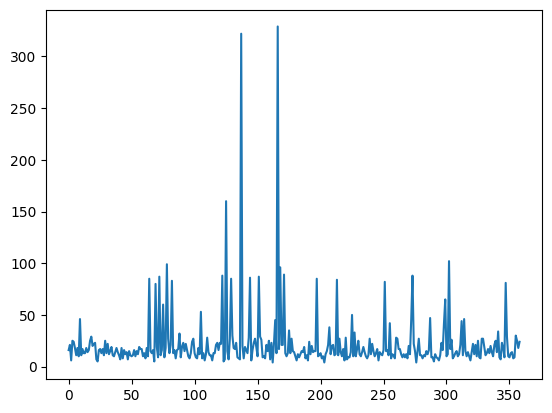

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()

In [ ]:
env = gym.make("CarRacing-v3", continuous = False)

#model = CNN(env.action_space.shape)
device = "cpu"
model = CNN(5).to(device)

rewards = train_reinforce(model, env, num_episodes=1000, gamma=0.8)

Episode 1/1000, Total Reward: -47.56554307116176, Time Elapsed: 1.1437415999998848 seconds
Action Time: 3.0760, Step Time: 13.0210, Sample Time: 0.0003, Q Time: 0.4496, Train Time: 0.6778
Episode 2/1000, Total Reward: -56.081081081081976, Time Elapsed: 1.2544779999998354 seconds
Action Time: 3.1139, Step Time: 13.3150, Sample Time: 0.0003, Q Time: 0.4726, Train Time: 0.7658
Episode 3/1000, Total Reward: -66.77740863787426, Time Elapsed: 1.2248517999996693 seconds
Action Time: 3.5338, Step Time: 13.7103, Sample Time: 0.0003, Q Time: 0.5036, Train Time: 0.7053
Episode 4/1000, Total Reward: -53.020134228188724, Time Elapsed: 1.5177099000002272 seconds
Action Time: 3.6519, Step Time: 14.7578, Sample Time: 0.0003, Q Time: 0.6439, Train Time: 0.8548
Episode 5/1000, Total Reward: -53.12500000000079, Time Elapsed: 1.5905063000000155 seconds
Action Time: 3.5124, Step Time: 15.5697, Sample Time: 0.0003, Q Time: 0.6278, Train Time: 0.9355
Episode 6/1000, Total Reward: -62.06896551724222, Time Ela

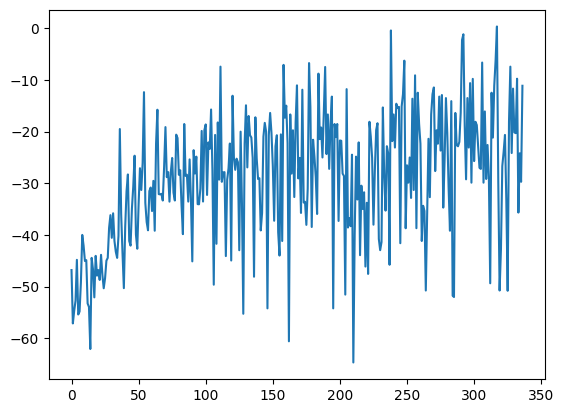

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()